#Functions and imports

**Installing dependencies**

*Run these cells if this is the first time that this notebook is being executed.*

In [1]:
#!pip install pysr

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pysr
from pysr import PySRRegressor
import pandas as pd
import itertools
import matplotlib.pyplot as plt

np.random.seed(100)

#Error eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

#Extra optimizer
from sklearn.linear_model import OrthogonalMatchingPursuit

#Danger zone:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide='ignore', invalid='ignore')   #the Wilcoxon test throws an error when there's a perfect fit

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

##Definitions

In [3]:
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

All structures below are quite similar, but we need to have a cell for each dynamics to take the equations into consideration correctly.

In [4]:
def volterra(t, y, a=2, b=0.5, c=1, d=0.375):
  u,v = y
  dudt = a*u - b*u*v
  dvdt = -c*v + d*b*u*v

  return [dudt, dvdt]

In [5]:
def pendulum(t, y):
    theta, omega = y
    g = 9.8
    L = 1.0

    d_theta = omega
    d_omega = - (g / L) * np.sin(theta)

    return [d_theta, d_omega]

In [6]:
def lorenz(t, ivp_sol, sigma=2.0, rho=1.0, beta=2.6):
  x, y, z = ivp_sol
  dx_dt = sigma * (y - x)
  dy_dt = x * (rho - z) - y
  dz_dt = x * y - beta * z

  return [dx_dt, dy_dt, dz_dt]

In [7]:
#=== SIS ===
def sis(t, y, beta = 0.3, gamma = 0.1):
  S, I = y
  dSdt = -beta * S * I + gamma * I
  dIdt = beta * S * I - gamma * I
  return [dSdt, dIdt]

In [8]:
#=== SIR ===
def sir(t, y, beta=0.3, gamma=0.1):
  S, I, R = y
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma*I
  return [dSdt, dIdt, dRdt]

In [9]:
#=== SEIR ===
def seir(t, y, beta=0.3, alpha=0.2, gamma=1.0):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

In [10]:
 #=== SEIRD ===
def seird(t, y, beta=0.3, alpha=0.2, gamma=1.0, mu=0.1):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [11]:
 #=== SIRV ===
def sirv(t, y, beta=0.5, gamma=1.0, nu=0.5):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

In [12]:
 #=== SIRS ===
def sirs(t, y, beta=0.3, gamma=1.0, nu=0.2):
    S, I, R = y
    dSdt = -beta * S * I + nu * R
    dIdt =  beta * S * I - gamma * I
    dRdt = gamma * I- nu * R
    return [dSdt, dIdt, dRdt]

##Error evaluation

In [25]:
def error_eval(models, dyn_name, curves_names, targets, ivp_sol):
  '''
  This function assumes you've run one of the eval_models() functions previously
  to estimate y_true and y_pred to keep it compatible with all dynamics.
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  y_preds = []
  statistics = []
  p_values = []
  wilcoxon_sol = []

  #Predict for each model found
  for n in list(range(len(models))):
    y_preds.append(models[n].predict(ivp_sol.y.T))

  #y_int = model.predict(init_params)
  len_sol = ivp_sol.y.T.shape[1]

  for i in range(len_sol):
    mse.append(mean_squared_error(y_preds[i], targets[i]))
    mae.append(mean_absolute_error(y_preds[i], targets[i]))
    r2.append(r2_score(y_preds[i], targets[i]))
    rmse.append(np.sqrt(mean_squared_error(y_preds[i], targets[i])))

    #Wilcoxon test
    if np.allclose(targets[i], y_preds[i], rtol=1e-5, atol=1e-8):
      stat, p_value = 0.0, 1.0
    else:
      try:
        stat, p_value = stats.wilcoxon(targets[i], y_preds[i], zero_method="pratt")# stats.wilcoxon(y_true, y_pred)
      except ValueError:
        stat, p_value = np.nan, 1.0

    statistics.append(stat)
    p_values.append(p_value)
    wilcoxon_sol.append(1 if p_value < 0.05 else 0)


  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse,
                           'wilcoxon_raw_value': statistics,
                           'p-value': p_values,
                           'is_difference': wilcoxon_sol})

  return res

#Dynamics to investigate

##Lorenz

In [15]:
#Parameters
feature_names = ['X', 'Y', 'Z']
t_start = 0.0
t_end = 5.0
t_step = 0.02
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

x0, y0, z0 = 0.6, 2.0, 1.0  # Condições iniciais
state0 = [x0, y0, z0]

In [16]:
#Solve the system
solution = solve_ivp(lorenz, t_span, state0, method='RK45', t_eval=t_eval)

#Target variables
dxdt = lorenz([0], solution.y)[0]
dydt = lorenz([0], solution.y)[1]
dzdt = lorenz([0], solution.y)[2]
targets = [dxdt,dydt,dzdt]

In [17]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#X axis
model_x = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_x.fit(solution.y.T, dxdt)

#Y axis
model_y = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_y.fit(solution.y.T, dydt)

#Z axis
model_z = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_z.fit(solution.y.T, dzdt)

#To the evaluations
models = [model_x, model_y, model_z]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 6.120e+05
Progress: 4188 / 50000 total iterations (8.376%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.441e-01  0.000e+00  y = -0.0066453
3           6.103e-02  6.931e-01  y = x₁ - x₀
5           4.034e-15  1.517e+01  y = (x₁ - x₀) * 2
7           4.033e-15  7.654e-05  y = ((x₀ - x₁) * -2) + 6.9967e-10
9           4.029e-15  5.870e-04  y = ((x₁ - x₀) * 2) + (x₂ * -8.3303e-09)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 6.770e+05
Progress: 9056 / 50000 total iterations (18.112%)
════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.441e-01  0.000e+00  y = -0.0066453
3           6.103e-02  6.931e-01  y = x₁ - x₀
5           4.034e-15  1.517e+01  y = (x₁ - x₀) * 2
7           4.032e-15  2.073e-04  y = ((x₀ - x₁) + 9.6983e-10) * -2
9           4.027e-15  6.741e-04  y = (((x₀ - x₁) * -2) + 0.35938) - 0.35938
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_151818_SIzESI/hall_of_fame.csv

Expressions evaluated per second: 6.480e+05
Progress: 4402 / 50000 total iterations (8.804%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.898e-01  0.000e+00  y = -0.30072
3           1.386e-02  1.309

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.600e+05
Progress: 14933 / 50000 total iterations (29.866%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.051e-02  0.000e+00  y = -0.18007
3           9.533e-03  7.234e-01  y = x₂ * -0.62398
5           5.726e-03  2.549e-01  y = (x₀ * 0.19854) - x₂
7           3.754e-15  1.403e+01  y = (x₀ * x₁) + (x₂ * -2.6)
9           2.193e-15  2.688e-01  y = ((x₀ * x₁) - (x₂ * 1.6)) - x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 7.730e+05
Progress: 20119 / 50000 total iterations (40.238%)
════════════════════════

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.051e-02  0.000e+00  y = -0.18007
3           9.533e-03  7.234e-01  y = x₂ * -0.62398
5           5.726e-03  2.549e-01  y = (x₀ * 0.19857) - x₂
7           3.754e-15  1.403e+01  y = (x₀ * x₁) + (x₂ * -2.6)
9           2.193e-15  2.688e-01  y = ((x₀ * x₁) - (x₂ * 1.6)) - x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_152012_STUzq1/hall_of_fame.csv


In [18]:
#Best equations:
print('dxdt =', model_x.sympy())
print('dydt =', model_y.sympy())
print('dzdt =', model_z.sympy())

dxdt = (-x0 + x1)*2.0
dydt = -x0*x2 + x0 - x1
dzdt = x0*x1 - 1.6*x2 - x2


In [26]:
res = error_eval(models, 'Lorenz', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lorenz,X,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,1.0,0
1,Lorenz,Y,2.753353e-17,3.106140e-33,1.0,5.573275e-17,0.0,1.0,0
2,Lorenz,Z,3.408385e-17,3.052214e-33,1.0,5.524684e-17,0.0,1.0,0


##Lotka-Volterra

In [27]:
#Parameters
feature_names = ['u', 'v']

t_start = 0.0
t_end = 7.5
t_step = 0.1
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([20, 5])

In [28]:
#Solve the system
solution = solve_ivp(volterra, t_span, state0, t_eval=t_eval)

#Target variables
dudt = volterra([0], solution.y)[0]
dvdt = volterra([0], solution.y)[1]
targets = [dudt,dvdt]

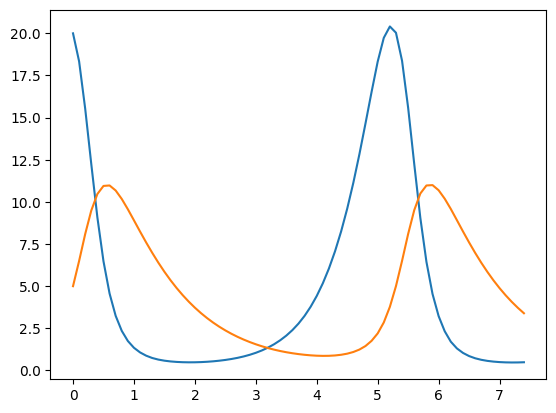

In [29]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [30]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#u axis
model_u = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_u.fit(solution.y.T, dudt)

#v axis
model_v = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_v.fit(solution.y.T, dvdt)

#To the evaluations
models = [model_u, model_v]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.870e+05
Progress: 5039 / 50000 total iterations (10.078%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.491e+02  0.000e+00  y = -2.6493
3           9.770e+01  2.113e-01  y = 2.335 - x₁
5           6.482e+01  2.051e-01  y = (x₁ * -2.6643) + 10.627
7           4.673e-13  1.628e+01  y = (2 - (x₁ * 0.5)) * x₀
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 8.500e+05
Progress: 10800 / 50000 total iterations (21.600%)
═══════════════════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.120e+05
Progress: 5254 / 50000 total iterations (10.508%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.680e+01  0.000e+00  y = x₀
3           9.018e+00  7.031e-01  y = x₀ - 5.2705
5           8.462e+00  3.182e-02  y = (x₀ + -5.2911) * 0.88002
7           1.281e-13  1.591e+01  y = x₁ * ((x₀ * 0.1875) + -1)
9           1.115e-13  6.911e-02  y = x₁ * (-2.23 * (0.44842 + (x₀ * -0.084079)))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 8.510e+05
Progress: 10769 / 50000 total iterations (21.538%)
════════════

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 9.070e+05
Progress: 44626 / 50000 total iterations (89.252%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.680e+01  0.000e+00  y = x₀
3           9.018e+00  7.031e-01  y = x₀ - 5.2705
5           8.462e+00  3.182e-02  y = (x₀ + -5.2911) * 0.88002
7           1.281e-13  1.591e+01  y = x₁ * ((x₀ * 0.1875) + -1)
9           1.078e-13  8.612e-02  y = (((x₀ * 0.1875) - 1.0626) + 0.062603) * x₁
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexi

In [31]:
#Best equations:
print('dudt =', model_u.sympy())
print('dvdt =', model_v.sympy())

dudt = x0*(2.0 - 0.5*x1)
dvdt = x1*(x0*0.1875 - 1.0)


In [32]:
res = error_eval(models, 'Lotka-Volterra', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lotka-Volterra,u,5.399847e-16,1.429888e-30,1.0,1.195779e-15,0.0,1.0,0
1,Lotka-Volterra,v,2.206568e-16,2.768235e-31,1.0,5.261402e-16,0.0,1.0,0


##Simple pendulum

In [33]:
#Parameters
feature_names = ['theta', 'omega']

t_start = 0.0
t_end = 10
t_step = 0.01
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([np.radians(45), 0])

In [34]:
#Solve the system
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval)

#Target variables
dthetadt = pendulum([0], solution.y)[0]
domegadt = pendulum([0], solution.y)[1]
targets = [dthetadt,domegadt]

In [35]:
dthetadt[:10]

array([ 0.        , -0.06928846, -0.13852888, -0.20767325, -0.2766736 ,
       -0.34548159, -0.41404844, -0.48232494, -0.55026148, -0.61780798])

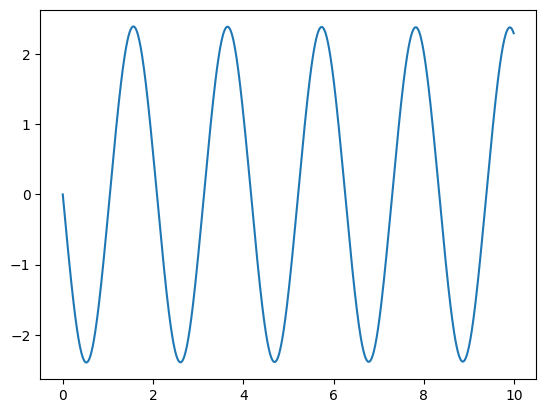

In [36]:
plt.plot(t_eval, dthetadt)

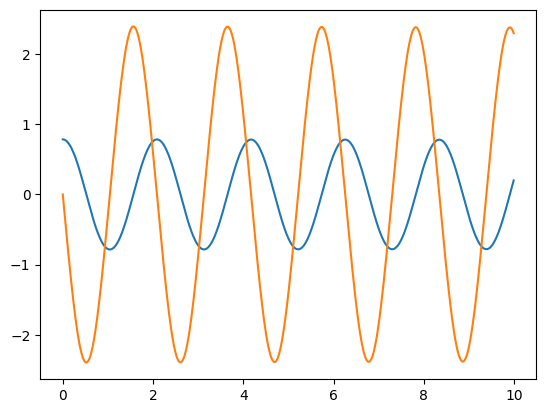

In [37]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [38]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#X axis
model_theta = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    random_state=42,
    **default_pysr_params
)
model_theta.fit(solution.y.T, dthetadt)

#Y axis
model_omega = PySRRegressor(
    maxsize=30,
    #niterations=1000,
    binary_operators=["*", "-"],
    unary_operators=['sin'],
    random_state=42,
    **default_pysr_params
)
model_omega.fit(solution.y.T, domegadt)


#To the evaluations
models = [model_theta, model_omega]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:1873: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.720e+05
Progress: 3002 / 50000 total iterations (6.004%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₁
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.870e+05
Progress: 6324 / 50000 total iterations (12.648%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:1873: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


  - outputs/20250724_152552_YYnTbt/hall_of_fame.csv

Expressions evaluated per second: 1.530e+05
Progress: 821 / 5000 total iterations (16.420%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.512e+01  0.000e+00  y = 0.22484
3           1.768e-02  3.629e+00  y = x₀ * -9.0666
4           5.966e-14  2.641e+01  y = sin(x₀) * -9.8
8           5.638e-14  1.413e-02  y = (x₀ * -8.6754e-07) - (sin(x₀) * 9.8)
12          5.597e-14  1.834e-03  y = (-7.3196e-07 * (x₀ * sin(sin(2.1482)))) - (sin(x₀) * 9...
                                      .8)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution ea

[ Info: Started!



Expressions evaluated per second: 1.560e+05
Progress: 1729 / 5000 total iterations (34.580%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.512e+01  0.000e+00  y = 0.22484
3           1.768e-02  3.629e+00  y = x₀ * -9.0666
4           5.966e-14  2.641e+01  y = sin(x₀) * -9.8
8           5.597e-14  1.596e-02  y = (x₀ * -5.4402e-07) - (sin(x₀) * 9.8)
13          5.570e-14  9.674e-04  y = (x₀ * (-7.1401e-07 - (1.8339e-07 * sin(x₁)))) - (sin(x...
                                      ₀) * 9.8)
16          5.564e-14  3.404e-04  y = ((sin(sin(x₀)) * -7.3196e-07) - (x₀ * (x₀ * 3.2689e-07...
                                      ))) - (sin(x₀) * 9.8)
19          5.559e-14  3.407e-04  y = ((sin(sin(x₀)) * -7.3196e-07) - ((3.2689e-07 * (x₀ - -...
                                      3.8

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250724_152707_G8VyHk/hall_of_fame.csv


In [39]:
#Best equations:
print('dthetadt =', model_theta.sympy())
print('domegadt =', model_omega.sympy())

dthetadt = x1
domegadt = sin(x0)*(-9.8)


In [40]:
res = error_eval(models, 'Pendulum', feature_names, targets=targets, ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Pendulum,theta,0.0,0.0,1.0,0.0,0.0,1.0,0
1,Pendulum,omega,0.0,0.0,1.0,0.0,0.0,1.0,0


##SIR

In [41]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [42]:
#Solve the SIR system
solution = solve_ivp(sir, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sir([0], solution.y)[0]
dIdt = sir([0], solution.y)[1]
dRdt = sir([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

In [43]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#R compartment
model_R = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_R.fit(solution.y.T, dRdt)

#To the evaluations
models = [model_S, model_I, model_R]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.450e+05
Progress: 3055 / 50000 total iterations (6.110%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.632e-04  0.000e+00  y = -0.0093667
3           6.658e-05  4.484e-01  y = x₁ * -0.099645
5           9.206e-19  1.596e+01  y = x₀ * (x₁ * -0.3)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.720e+05
Progress: 6389 / 50000 total iterations (12.778%)
════════════════════════════════════════════════════════════════════════════════════════════════════
────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.220e+05
Progress: 2855 / 50000 total iterations (5.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.658e-05  0.000e+00  y = 4.4627e-06
3           5.486e-05  9.684e-02  y = x₀ * 0.0063696
5           4.317e-05  1.198e-01  y = (x₀ * 0.012742) - 0.0048369
7           6.929e-19  1.588e+01  y = x₁ * (-0.1 - (x₀ * -0.3))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.190e+05
Progress: 5665 / 50000 total iterations (11.330%)
══════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.658e-05  0.000e+00  y = 4.4627e-06
3           5.486e-05  9.684e-02  y = x₀ * 0.0063696
5           4.317e-05  1.198e-01  y = (x₀ * 0.012742) - 0.0048369
7           6.929e-19  1.588e+01  y = x₁ * (-0.1 - (x₀ * -0.3))
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_152852_eSRa8e/hall_of_fame.csv

Expressions evaluated per second: 4.490e+05
Progress: 3072 / 50000 total iterations (6.144%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.809e-05  0.000e+00  y = 0.0093603
3           3.716e-19  1.660e+01  y = x₁ * 0.1
5           3.716e-19  1.788e-07  y = -4

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.170e+05
Progress: 46404 / 50000 total iterations (92.808%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.809e-05  0.000e+00  y = 0.0093632
3           3.716e-19  1.660e+01  y = x₁ * 0.1
5           3.716e-19  1.788e-07  y = -4.3769e-12 - (x₁ * -0.1)
7           3.199e-19  7.480e-02  y = 0.00026686 - ((x₁ + -0.0026686) * -0.1)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.170e+05
Progress: 49881 / 50000 total iterations (99.762%)
══════════════════════════════════════════════════════════════════════════

In [44]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dIdt =', model_I.sympy())
print('dRdt =', model_R.sympy())

dSdt = x0*x1*(-0.29999998)
dIdt = x1*(-(-0.29999998)*x0 - 0.099999994)
dRdt = x1*0.1


In [45]:
res = error_eval(models, 'SIR', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIR,S,6.244449e-10,1.115480e-18,1.0,1.056163e-09,0.0,1.0,0
1,SIR,I,3.872646e-10,3.035759e-19,1.0,5.509773e-10,0.0,1.0,0
2,SIR,R,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,1.0,0


##SIS

In [46]:
#Parameters
feature_names = ['S', 'I']
#Time
t = np.linspace(0, 10, 100)
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

#SIS
N = 1
I0 = 0.001
S0 = N - I0
x0 = np.array([S0, I0])

In [47]:
#Solve the SIS system
solution = solve_ivp(sis, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sis([0], solution.y)[0]
dIdt = sis([0], solution.y)[1]
targets = [dSdt,dIdt]

In [48]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#To the evaluations
models = [model_S, model_I]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.290e+05
Progress: 2927 / 50000 total iterations (5.854%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.037e-04  0.000e+00  y = -0.006646
3           9.603e-05  3.834e-02  y = x₀ * -0.011703
5           9.582e-05  1.096e-03  y = (x₁ * 0.010213) + -0.011239
7           5.216e-18  1.527e+01  y = x₁ * (0.1 - (x₀ * 0.3))
9           1.829e-18  5.241e-01  y = ((x₁ - (x₀ + x₀)) * x₁) * 0.1
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.450e+05
Progress: 6088 / 50000 total iterations (12.176%)
═════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.120e+05
Progress: 2906 / 50000 total iterations (5.812%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.037e-04  0.000e+00  y = 0.0066465
3           9.603e-05  3.834e-02  y = x₀ * 0.011704
5           9.582e-05  1.096e-03  y = (x₀ * 0.010209) + 0.0010277
7           5.216e-18  1.527e+01  y = x₁ * ((x₀ * 0.3) + -0.1)
9           4.601e-18  6.281e-02  y = ((x₀ * 0.2) - (x₁ * 0.1)) * x₁
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.280e+05
Progress: 5856 / 50000 total iterations (11.712%)
════════════════

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.037e-04  0.000e+00  y = 0.0066465
3           9.603e-05  3.834e-02  y = x₀ * 0.011703
5           9.582e-05  1.096e-03  y = (x₀ * 0.010209) + 0.0010277
7           5.216e-18  1.527e+01  y = x₁ * ((x₀ * 0.3) + -0.1)
9           1.809e-18  5.295e-01  y = ((x₀ + x₀) - x₁) * (x₁ * 0.1)
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_153240_4Rv1aV/hall_of_fame.csv


In [49]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dIdt =', model_I.sympy())

dSdt = (x1 - (x0 + x0))*x1*0.1
dIdt = (x0 + x0 - x1)*x1*0.1


In [50]:
res = error_eval(models, 'SIS', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIS,S,5.016526e-18,5.315209e-35,1.0,7.290548e-18,0.0,1.0,0
1,SIS,I,5.016526e-18,5.315209e-35,1.0,7.290548e-18,0.0,1.0,0


##SEIR

In [51]:
#Parameters
feature_names = ['S', 'E', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - E0
x0 = np.array([S0, E0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2

In [52]:
#Solve the SEIR system
solution = solve_ivp(seir, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0))

#Target variables
dSdt = seir([0], solution.y)[0]
dEdt = seir([0], solution.y)[1]
dIdt = seir([0], solution.y)[2]
dRdt = seir([0], solution.y)[3]
targets = [dSdt,dEdt,dIdt,dRdt]

In [53]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#E compartment
model_E = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_E.fit(solution.y.T, dEdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#R compartment
model_R = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_R.fit(solution.y.T, dRdt)

#To the evaluations
models = [model_S, model_E, model_I, model_R]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.960e+05
Progress: 2862 / 50000 total iterations (5.724%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.072e-10  0.000e+00  y = -4.4741e-06
3           3.930e-18  9.338e+00  y = x₂ * -0.29967
5           4.223e-20  2.267e+00  y = (x₂ * x₀) * -0.3
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.400e+05
Progress: 6276 / 50000 total iterations (12.552%)
════════════════════════════════════════════════════════════════════════════════════════════════════
────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.840e+05
Progress: 6892 / 50000 total iterations (13.784%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.205e-10  0.000e+00  y = 2.0649e-07
3           8.520e-11  7.982e-01  y = x₂ * 0.23897
5           2.494e-11  6.143e-01  y = (x₂ - x₁) * 0.28203
7           5.814e-13  1.879e+00  y = ((x₁ * -0.65472) + x₂) * 0.28889
9           1.258e-13  7.655e-01  y = ((x₁ * -0.19871) + (x₂ * -0.70528)) + x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.000e+05
Progress: 10579 / 50000 total iterations (21.158%)
════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.205e-10  0.000e+00  y = 2.0521e-07
3           8.520e-11  7.982e-01  y = x₂ * 0.23898
5           2.494e-11  6.143e-01  y = (x₂ - x₁) * 0.28191
7           2.846e-15  4.539e+00  y = (x₁ * -0.19959) + (x₂ * 0.30019)
9           7.057e-16  6.972e-01  y = (x₁ * -0.19959) + (x₂ * (0.30019 - x₃))
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_153507_Tx6q9J/hall_of_fame.csv

Expressions evaluated per second: 4.540e+05
Progress: 3310 / 50000 total iterations (6.620%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.152e-09  0.000e+00  y = -1.0664e-05
3         

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


  - outputs/20250724_153616_5BY09b/hall_of_fame.csv

Expressions evaluated per second: 4.710e+05
Progress: 3368 / 50000 total iterations (6.736%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.890e+05
Progress: 6950 / 50000 total iterations (13.900%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss    

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.270e+05
Progress: 47417 / 50000 total iterations (94.834%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_153724_aZBT3Q/hall_of_fame.csv


In [54]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dEdt =', model_E.sympy())
print('dIdt =', model_I.sympy())
print('dRdt =', model_R.sympy())

dSdt = (x0*x0*x2 + x2)*(-0.14999992)
dEdt = x1*(-0.19958815) + x2*(0.30018672 - x3)
dIdt = x1*(0.20000175 - x3*x3) - x2
dRdt = x2


In [55]:
res = error_eval(models, 'SEIR', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIR,S,9.837967e-13,8.288963e-24,1.000000,2.879056e-12,0.0,1.000000e+00,0
1,SEIR,E,7.060008e-09,7.056901e-16,0.999998,2.656483e-08,126277.0,6.000654e-42,1
2,SEIR,I,1.022180e-11,1.396529e-21,1.000000,3.737016e-11,0.0,1.000000e+00,0
3,SEIR,R,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.0,1.000000e+00,0


##SEIRD

In [56]:
#Parameters
feature_names = ['S', 'E', 'I', 'R', 'D']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0, D0 = 0.001, 0.0, 0.0, 0.0
S0 = N - I0 - R0 - E0 - D0
x0 = np.array([S0, E0, I0, R0, D0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2
mu = 0.1

In [57]:
#Solve the SEIR system
solution = solve_ivp(seird, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0, 0.1))

#Target variables
dSdt = seird([0], solution.y)[0]
dEdt = seird([0], solution.y)[1]
dIdt = seird([0], solution.y)[2]
dRdt = seird([0], solution.y)[3]
dDdt = seird([0], solution.y)[3]
targets = [dSdt,dEdt,dIdt,dRdt,dDdt]

In [58]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#E compartment
model_E = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_E.fit(solution.y.T, dEdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#R compartment
model_R = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_R.fit(solution.y.T, dRdt)

#D compartment
model_D = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_D.fit(solution.y.T, dDdt)

#To the evaluations
models = [model_S, model_E, model_I, model_R, model_D]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.400e+05
Progress: 3176 / 50000 total iterations (6.352%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.625e-10  0.000e+00  y = -3.9409e-06
3           2.800e-18  9.461e+00  y = x₂ * -0.29967
5           2.008e-19  1.318e+00  y = (x₀ * -0.30001) * x₂
9           2.001e-19  8.324e-04  y = ((x₀ * (-0.30001 * x₂)) - x₂) + x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.670e+05
Progress: 6740 / 50000 total iterations (13.480%)
════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.625e-10  0.000e+00  y = -3.941e-06
3           2.790e-18  9.463e+00  y = x₂ * -0.29967
5           2.222e-24  7.022e+00  y = x₀ * (x₂ * -0.3)
9           1.478e-24  1.019e-01  y = x₂ * (-0.3 * (x₀ + (x₂ * x₁)))
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_153833_v8STsl/hall_of_fame.csv

Expressions evaluated per second: 4.350e+05
Progress: 3126 / 50000 total iterations (6.252%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.918e-10  0.000e+00  y = 2.0811e-07
3           7.073e-11  8.560e-01  y = x₂ * 0.24558
5           2.031e-11  6.240e-01  y = (x₁ 

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.390e+05
Progress: 3136 / 50000 total iterations (6.272%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.779e-09  0.000e+00  y = -1.0746e-05
3           7.071e-11  2.202e+00  y = x₂ * -1.0459
5           4.363e-11  2.414e-01  y = (0.13385 * x₁) - x₂
7           7.769e-12  8.629e-01  y = (0.13385 * x₁) + (x₂ * -1.0846)
9           5.472e-13  1.327e+00  y = (((x₁ * 0.36289) - x₂) - x₂) * 0.55525
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.580e+05
Progress: 6584 / 50000 total iterations (13.168%)
════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.779e-09  0.000e+00  y = -1.0745e-05
3           7.071e-11  2.202e+00  y = x₂ * -1.0459
5           4.363e-11  2.414e-01  y = (x₁ * 0.1332) - x₂
7           8.654e-14  3.111e+00  y = ((-0.17874 * x₁) + x₂) * -1.0956
9           5.054e-14  2.689e-01  y = ((-0.17874 * x₁) + x₂) * (-1.0956 + -0.0012204)
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_154055_mN0N0g/hall_of_fame.csv

Expressions evaluated per second: 4.670e+05
Progress: 3359 / 50000 total iterations (6.718%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.320e+05
Progress: 3102 / 50000 total iterations (6.204%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.630e+05
Progress: 6700 / 50000 total iterations (13.400%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.470e+05
Progress: 43021 / 50000 total iterations (86.042%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₂
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.460e+05
Progress: 46781 / 50000 total iterations (93.562%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.0

In [59]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dEdt =', model_E.sympy())
print('dIdt =', model_I.sympy())
print('dRdt =', model_R.sympy())
print('dddt =', model_D.sympy())

dSdt = x2*(-0.29999998)*(x0 + x1*x2)
dEdt = (x1*0.6675452 - x2)*(-0.29968923)
dIdt = (-1.0956345 - 0.0012204179)*(-0.1787395*x1 + x2)
dRdt = x2
dddt = x2


In [60]:
res = error_eval(models, 'SEIRD', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIRD,S,1.421775e-13,6.401412e-25,1.000000,8.000883e-13,0.0,1.000000e+00,0
1,SEIRD,E,6.808034e-10,2.526406e-18,1.000000,1.589467e-09,0.0,1.000000e+00,0
2,SEIRD,I,6.974697e-08,5.054005e-14,0.999991,2.248111e-07,118246.0,2.525964e-47,1
3,SEIRD,R,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.0,1.000000e+00,0
4,SEIRD,D,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.0,1.000000e+00,0


##SIRV

In [61]:
#Parameters
feature_names = ['S', 'I', 'R', 'V']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, V0 = 0.001, 0.0, 0.5
S0 = N - I0 - R0 - V0
x0 = np.array([S0, I0, R0, V0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.5

In [62]:
#Solve the SIR system
solution = solve_ivp(sirv, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sirv([0], solution.y)[0]
dIdt = sirv([0], solution.y)[1]
dRdt = sirv([0], solution.y)[2]
dVdt = sirv([0], solution.y)[3]
targets = [dSdt,dIdt,dRdt,dVdt]

In [63]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#R compartment
model_R = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_R.fit(solution.y.T, dRdt)

#V compartment
model_V = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_V.fit(solution.y.T, dVdt)

#To the evaluations
models = [model_S, model_I, model_R, model_V]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.570e+05
Progress: 3141 / 50000 total iterations (6.282%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.284e-04  0.000e+00  y = -0.0051172
3           5.623e-11  8.115e+00  y = x₀ * -0.50029
5           1.660e-11  6.100e-01  y = (x₀ + x₁) * -0.49952
7           1.381e-18  8.151e+00  y = ((x₁ * x₀) + x₀) * -0.5
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.790e+05
Progress: 6626 / 50000 total iterations (13.252%)
════════════════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.284e-04  0.000e+00  y = -0.0051172
3           5.623e-11  8.115e+00  y = x₀ * -0.50029
5           1.660e-11  6.100e-01  y = (x₀ + x₁) * -0.49952
7           1.381e-18  8.151e+00  y = ((x₁ * x₀) + x₀) * -0.5
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_154427_48ySWL/hall_of_fame.csv

Expressions evaluated per second: 4.120e+05
Progress: 2941 / 50000 total iterations (5.882%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.225e-09  0.000e+00  y = -1.0477e-05
3           1.377e-11  2.863e+00  y = x₁ * -0.80314
5           1.357e-11  7.297e-03  y = (x₁ *

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.225e-09  0.000e+00  y = -1.0471e-05
3           1.377e-11  2.863e+00  y = x₁ * -0.80312
5           1.357e-11  7.297e-03  y = (x₁ * -0.80227) + -4.5259e-07
7           3.960e-21  1.098e+01  y = (0.5 * (x₀ * x₁)) - x₁
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20250724_154539_dotthn/hall_of_fame.csv

Expressions evaluated per second: 4.660e+05
Progress: 3278 / 50000 total iterations (6.556%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = x₁
───────────────────────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.660e+05
Progress: 3195 / 50000 total iterations (6.390%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.276e-04  0.000e+00  y = 0.0051172
3           0.000e+00  5.164e+01  y = x₀ * 0.5
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.890e+05
Progress: 6652 / 50000 total iterations (13.304%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss  

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.480e+05
Progress: 49352 / 50000 total iterations (98.704%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.276e-04  0.000e+00  y = 0.0051172
3           0.000e+00  5.164e+01  y = x₀ * 0.5
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.276e-04  0.000e+00  y = 0.0051172
3           0.000e+00  5.164e+01  y = x₀ * 0.5
──────────────────────────────────────────────────────────────────────────

In [64]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dIdt =', model_I.sympy())
print('dRdt =', model_R.sympy())
print('dVdt =', model_V.sympy())

dSdt = (x0*x1 + x0)*(-0.5)
dIdt = 0.5000019*x0*x1 - x1
dRdt = x1
dVdt = x0*0.5


In [65]:
res = error_eval(models, 'SIRV', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRV,S,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,1.0,0
1,SIRV,I,7.674076e-12,3.949245e-21,1.0,6.284302e-11,0.0,1.0,0
2,SIRV,R,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,1.0,0
3,SIRV,V,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0,1.0,0


##SIRS

In [66]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [67]:
#Solve the SIR system
solution = solve_ivp(sirs, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sirs([0], solution.y)[0]
dIdt = sirs([0], solution.y)[1]
dRdt = sirs([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

In [68]:
#Applies PySR to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#S compartment
model_S = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_S.fit(solution.y.T, dSdt)

#I compartment
model_I = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_I.fit(solution.y.T, dIdt)

#R compartment
model_R = PySRRegressor(
    maxsize=10,
    niterations=1000,
    binary_operators=["+", "*", "-"],
    unary_operators=[ ],
    #denoise=True,
    **default_pysr_params
)
model_R.fit(solution.y.T, dRdt)

#To the evaluations
models = [model_S, model_I, model_R]

/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.680e+05
Progress: 3354 / 50000 total iterations (6.708%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.227e-09  0.000e+00  y = 9.8038e-06
3           5.448e-10  4.059e-01  y = x₂ * 0.14008
5           7.598e-11  9.849e-01  y = (x₂ - x₁) * 0.19914
7           1.521e-12  1.956e+00  y = (x₂ * 0.19409) + (x₁ * -0.28612)
9           1.378e-12  4.925e-02  y = (((x₂ - x₁) * -1.8416) + x₁) * -0.1107
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.940e+05
Progress: 7041 / 50000 total iterations (14.082%)
════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.890e+05
Progress: 6965 / 50000 total iterations (13.930%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.644e-09  0.000e+00  y = -1.0395e-05
3           2.085e-18  1.064e+01  y = x₁ * -0.70032
5           2.070e-18  3.678e-03  y = 1.0471e-10 - (x₁ * 0.70032)
7           3.441e-19  8.972e-01  y = (x₀ * x₁) * (x₀ + -1.7)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.030e+05
Progress: 10584 / 50000 total iterations (21.168%)
══════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/home/llober/.local/srenv/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


  - outputs/20250724_155021_Fj0BZw/hall_of_fame.csv

Expressions evaluated per second: 4.730e+05
Progress: 3293 / 50000 total iterations (6.586%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.586e-09  0.000e+00  y = x₁
3           1.258e-09  1.160e-01  y = x₁ * 0.7928
5           4.311e-21  1.320e+01  y = x₁ - (x₂ * 0.2)
7           2.963e-22  1.339e+00  y = x₁ + (x₂ - (x₂ * 1.2))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.820e+05
Progress: 6853 / 50000 total iterations (13.706%)
════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 5.440e+05
Progress: 28920 / 50000 total iterations (57.840%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.586e-09  0.000e+00  y = x₁
3           1.258e-09  1.160e-01  y = x₁ * 0.79281
5           1.734e-22  1.481e+01  y = x₁ + (x₂ * -0.2)
9           1.705e-22  4.156e-03  y = ((x₁ + x₁) + (x₂ * -0.2)) - x₁
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.460e+05
Progress: 32690 / 50000 total iterations (65.380%)
═══════════════════════════════════════════════════════════════════════════════════════════════

In [69]:
#Best equations:
print('dSdt =', model_S.sympy())
print('dIdt =', model_I.sympy())
print('dRdt =', model_R.sympy())

dSdt = -0.20024376*x0*(x1*1.4996295 - x2)
dIdt = x0*x1*0.30000055 - x1
dRdt = x1 + x2*(-0.19999999)


In [71]:
res = error_eval(models, 'SIRS', feature_names, targets=targets, ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRS,S,1.022315e-08,8.748631e-16,0.999999,2.957808e-08,147828.0,3.586408e-29,1
1,SIRS,I,8.244741e-12,2.309175e-21,1.000000,4.805387e-11,0.0,1.000000e+00,0
2,SIRS,R,7.165678e-13,3.964532e-24,1.000000,1.991113e-12,0.0,1.000000e+00,0
